<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to the Allen Brain Observatory dataset and SDK functions. 

<p>It will then get into doing some fun things with these data!
    
    
</div>

In [2]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The main entry point is the `BrainObservatoryCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded into data assetts on codeocean - These data are big, and this will save us a lot of bandwidth and time.

<p>We begin by importing the `BrainObservatoryCache` class and instantiating it.

<p>`manifest_path` is a path to the manifest file. 
</div>

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

#drive_path = '/data/allen-brain-observatory/visual-coding-2p'
drive_path = r'D:/VisualCoding2p'

manifest_file = os.path.join(drive_path,'manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Get information about what's in the dataset from BrainObservatoryCache

<p>The following methods for BrainObservatoryCache retrieve the available depths, cre lines, areas, and stimuli.
</div>

In [4]:
targeted_structures = boc.get_all_targeted_structures()
print('all targeted structures: ' + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [5]:
# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print('all imaging depths: ' + str(depths))

all imaging depths: [175, 185, 195, 200, 205, 225, 250, 265, 275, 276, 285, 300, 320, 325, 335, 350, 365, 375, 390, 400, 550, 570, 625]


In [6]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print('all cre lines: ' + str(cre_lines))

all cre lines: ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Fezf2-CreER', 'Nr5a1-Cre', 'Ntsr1-Cre_GN220', 'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre', 'Slc17a7-IRES2-Cre', 'Sst-IRES-Cre', 'Tlx3-Cre_PL56', 'Vip-IRES-Cre']


In [7]:
# Download a list of all stimuli
stims = boc.get_all_stimuli()
print('all stimuli: ' + str(stims))

all stimuli: ['drifting_gratings', 'locally_sparse_noise', 'locally_sparse_noise_4deg', 'locally_sparse_noise_8deg', 'natural_movie_one', 'natural_movie_three', 'natural_movie_two', 'natural_scenes', 'spontaneous', 'static_gratings']


In [8]:
# Hit the 'tab' key with the cursor just after the '.'
boc.

SyntaxError: invalid syntax (2978251516.py, line 2)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h1>Data Structure and Organization</h1>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Experiment containers</h2>
<p>The experiment container describes a set of 3 experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. Each experiment container has a unique ID number.
</div>

Typically, you choose data by experimentaly parameters you are interested in. Here lets start with a cre line and a visual area.

In [9]:
visual_area = 'VISp'
cre_line ='Emx1-IRES-Cre'

You can then query the 'BrainObservatoryCache' for experiment containers that meet your criteria.

In [10]:
exps = boc.get_experiment_containers(targeted_structures=[visual_area], cre_lines=[cre_line])

In [11]:
#make a pandas DataFrame to see what information we have on these experiments
pd.DataFrame(exps)

,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
0,517328083,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),237706,Emx1-IRES-Cre;Camk2a-tTA;Ai93-237706,[Epileptiform Events],False
1,536323956,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,[],False
2,540168835,375,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),261458,Emx1-IRES-Cre;Camk2a-tTA;Ai93-261458,[],False
3,595263152,375,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),309152,Emx1-IRES-Cre;Camk2a-tTA;Ai93-309152,[],False
4,561312433,275,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),280638,Emx1-IRES-Cre;Camk2a-tTA;Ai93-280638,[],False
5,595906107,275,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),309152,Emx1-IRES-Cre;Camk2a-tTA;Ai93-309152,[],False
6,595806298,375,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),311728,Emx1-IRES-Cre;Camk2a-tTA;Ai93-311728,[],False
7,543677425,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),260936,Emx1-IRES-Cre;Camk2a-tTA;Ai93-260936,[],False
8,545578995,375,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),260936,Emx1-IRES-Cre;Camk2a-tTA;Ai93-260936,[],False
9,527676429,275,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),237706,Emx1-IRES-Cre;Camk2a-tTA;Ai93-237706,[Epileptiform Events],False


Now, we can select an experimental container and pull out an individual session to look at

In [12]:
expt_container_id = 536323956

In [13]:
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id])
expt_session_info_df = pd.DataFrame(expt_session_info)
expt_session_info_df

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,540684467,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),120,536323956,three_session_A,252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,False
1,541048140,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),121,536323956,three_session_B,252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,False
2,539515366,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),113,536323956,three_session_C,252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,False


Though each session is tagged with a session type, we can also use the 'BrainObservatoryCache' object to get more the specifics about what is in each session.

In [31]:
session_id = expt_session_info_df.id[0]
boc.get_ophys_experiment_stimuli(session_id)

['drifting_gratings',
 'natural_movie_one',
 'natural_movie_three',
 'spontaneous']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Dataset Object</h2>
<p>Each session has a unique `session_id.' These can be used to query a data_set object

</div>

In [16]:
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

2023-07-10 20:09:49,616 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/539937476


In [26]:
data_set.get_metadata()

{'sex': 'male',
 'targeted_structure': 'VISp',
 'ophys_experiment_id': 539515366,
 'experiment_container_id': 536323956,
 'excitation_lambda': '910 nanometers',
 'indicator': 'GCaMP6f',
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'session_start_time': datetime.datetime(2016, 8, 16, 12, 12, 14),
 'session_type': 'three_session_C',
 'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174',
 'cre_line': 'Emx1-IRES-Cre/wt',
 'imaging_depth_um': 175,
 'age_days': 114,
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.1',
 'pipeline_version': '3.0'}

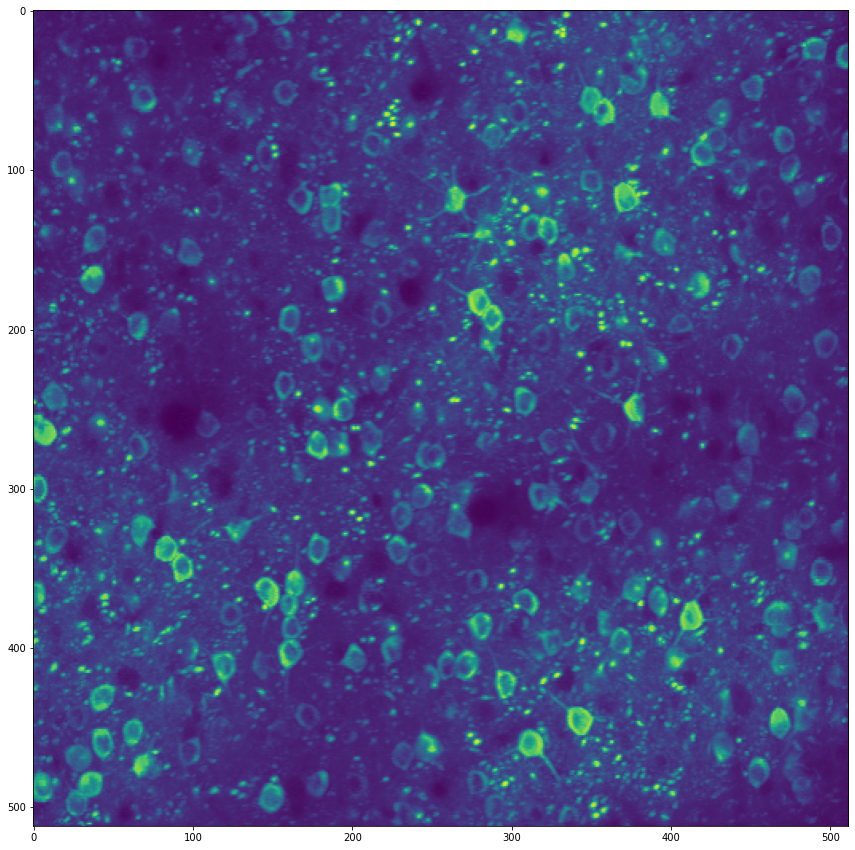

In [27]:
mxproj = data_set.get_max_projection()
fig,ax  = plt.subplots(figsize = (15,15))
ax.imshow(mxproj)

Number of labels: 233


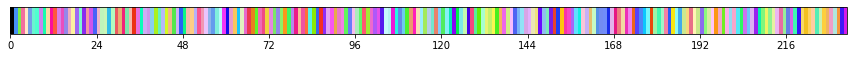

In [28]:
# THis is just fancy code to give each cell a random, unique color - don't worry
# about it.
# In fact, it would be far better  if this were bumped to a different script
# somewhere to obviscate it.

def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    
    from https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

cm = rand_cmap(len(msks)+1)

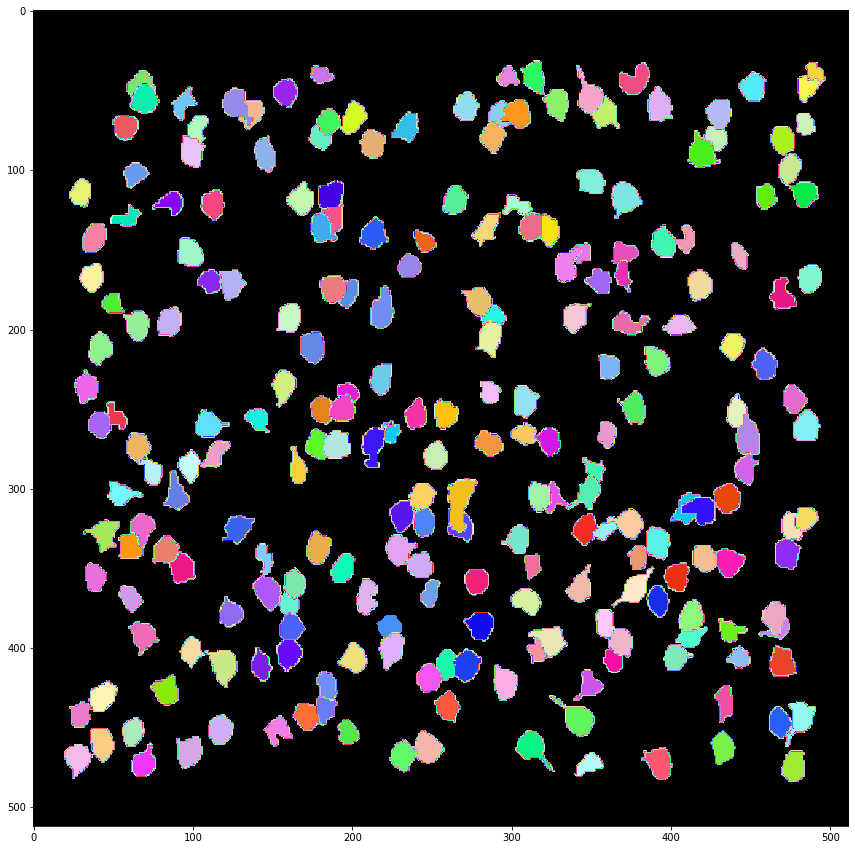

In [29]:
msks = data_set.get_roi_mask_array()

roi_id = np.zeros(msks[0].shape)
for ii, msk in enumerate(msks):
    roi_id[msk==1] = ii
fig,ax  = plt.subplots(figsize = (15,15))
ax.imshow(roi_id,cmap =cm)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Analysis Object</h2>


<p>The analysis objects summarize the trial data for a stimulus type and provide convenient DataFrame objects.  
</div>

In [33]:
gratings = boc.get_ophys_experiment_analysis(ophys_experiment_id=session_id, stimulus_type='drifting_gratings')
gratings.dfftraces.shape

(290, 115741)

In [34]:
print(gratings.cell_id)

[541513230 541513204 541513191 541513775 541512700 541512223 541513979
 541512161 541511853 541513083 541513462 541512818 541512808 541513264
 541512836 541513499 541512344 541513723 589212492 541512464 541513169
 541512377 541513140 589210599 541512117 541511675 541512168 541511697
 541511847 541511702 541511844 541512153 541511436 541512251 541512255
 541512245 541511670 541511986 541511552 541511572 541512447 541511491
 541511503 541513483 541512611 541511473 541513784 541511950 541511945
 541511977 541511460 541511731 541511972 541511970 589213208 541513006
 541511905 541511895 541512947 541511900 541513624 589210770 541513633
 541513630 541512233 541511413 541513734 541512407 589213299 589213249
 541511955 541511960 541511982 541511557 541512058 589213175 541511807
 541512663 541511935 541511940 541511915 541512950 541511920 541511930
 541512175 541511399 541512063 541511389 541511888 541511309 541513196
 541512155 541511682 541512508 541513177 541511687 541512261 541511692
 54151

In [35]:
cell_id = 541513979
cell_idx = np.where(cell_id==gratings.cell_id)[0]

In [36]:
this_dff = gratings.dfftraces[cell_idx][0]
this_dff

array([0.20787542, 0.24110101, 0.24538985, ..., 0.56033623, 0.59997416,
       0.7451735 ], dtype=float32)

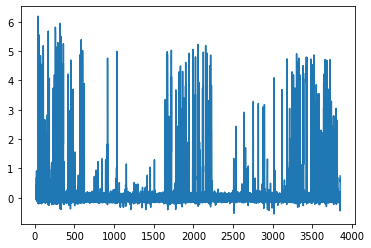

In [37]:
plt.plot(gratings.timestamps,this_dff)

In [38]:
stim_table = gratings.stim_table
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,0.0,0.0,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


Text(0.5, 0, 'Frames')

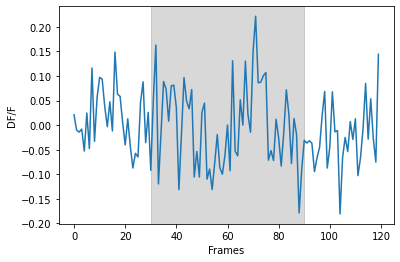

In [39]:
plt.plot(this_dff[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

Text(0.5, 0, 'Frames')

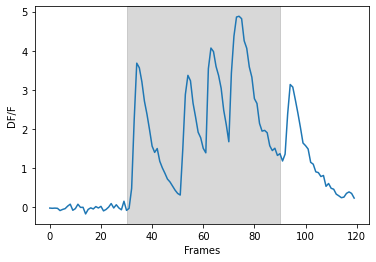

In [40]:
plt.plot(this_dff[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [41]:
this_stim_table = gratings.stim_table[(gratings.stim_table.temporal_frequency==15) & (gratings.stim_table.orientation==90)]
this_stim_table

,temporal_frequency,orientation,blank_sweep,start,end
1,15.0,90.0,0.0,826,886
48,15.0,90.0,0.0,5081,5141
97,15.0,90.0,0.0,9516,9576
134,15.0,90.0,0.0,12865,12925
170,15.0,90.0,0.0,16124,16184
188,15.0,90.0,0.0,17755,17814
254,15.0,90.0,0.0,53602,53661
332,15.0,90.0,0.0,60662,60722
349,15.0,90.0,0.0,62200,62260
410,15.0,90.0,0.0,95783,95843


In [42]:
len(this_stim_table)

15

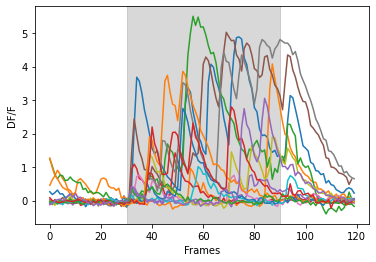

In [43]:
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented

# THIS IS A SUPER HANDY WAY TO INTERATE THROUGH A TABLE!!!
for ii,row in this_stim_table.iterrows():
    plt.plot(this_dff[int(row.start)-30:int(row.end)+30])
    plt.ylabel("DF/F")
    plt.xlabel("Frames")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h1>And Now for some data wrangling</h1>
</div>

In [241]:
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))
#mean_response= np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    response[ii,:] = this_dff[stim_table.start[ii]:stim_table.start[ii]+60]

In [242]:
orientations,ix = np.unique(orientation,return_inverse=True)
orientations

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

In [243]:
ix

array([1, 2, 6, 0, 2, 6, 3, 6, 1, 0, 5, 2, 0, 0, 3, 5, 6, 0, 5, 7, 4, 7,
       0, 2, 3, 0, 7, 4, 0, 3, 6, 3, 3, 0, 0, 4, 1, 5, 4, 7, 6, 5, 3, 4,
       2, 5, 3, 2, 2, 3, 0, 3, 1, 0, 7, 4, 7, 4, 6, 5, 0, 5, 0, 7, 1, 6,
       6, 2, 7, 7, 6, 7, 7, 5, 2, 4, 2, 2, 0, 6, 3, 5, 2, 3, 6, 0, 7, 5,
       4, 3, 7, 3, 7, 0, 2, 6, 6, 2, 4, 7, 7, 5, 5, 3, 3, 7, 4, 6, 0, 6,
       7, 6, 7, 1, 5, 7, 1, 3, 7, 5, 0, 4, 5, 5, 1, 1, 1, 3, 6, 4, 4, 6,
       4, 5, 2, 7, 5, 3, 1, 2, 1, 6, 7, 4, 3, 0, 0, 5, 4, 6, 1, 7, 0, 4,
       4, 0, 6, 3, 4, 6, 1, 4, 1, 4, 5, 0, 0, 3, 1, 0, 2, 4, 5, 1, 5, 1,
       3, 6, 5, 4, 6, 5, 2, 6, 6, 7, 5, 4, 2, 3, 5, 0, 5, 7, 5, 6, 0, 1,
       0, 3, 5, 7, 7, 0, 3, 6, 0, 5, 3, 0, 6, 0, 4, 4, 2, 0, 1, 5, 6, 4,
       0, 6, 2, 5, 6, 6, 0, 0, 5, 3, 4, 2, 3, 3, 0, 7, 0, 3, 0, 5, 0, 4,
       3, 0, 0, 0, 0, 3, 1, 4, 6, 2, 6, 4, 2, 5, 7, 0, 5, 6, 4, 3, 3, 6,
       6, 6, 3, 5, 1, 2, 3, 4, 1, 7, 1, 7, 7, 3, 6, 5, 1, 3, 1, 4, 2, 3,
       7, 0, 4, 1, 1, 2, 6, 6, 0, 4, 6, 7, 5, 3, 2,

Text(0.5, 0, 'time (frames from stim onset)')

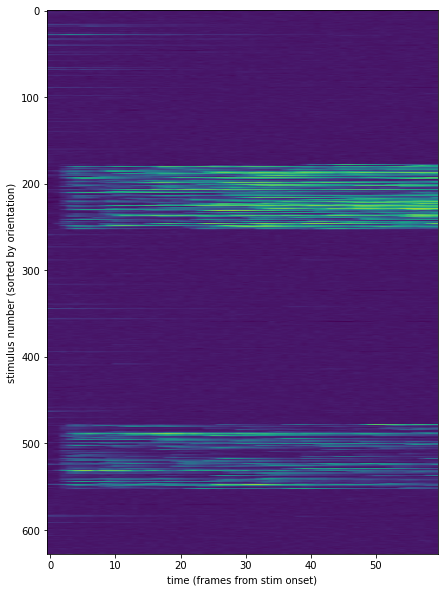

In [250]:
sort_order = np.argsort(ix)
fig,ax = plt.subplots(figsize=(7,10))
ax.imshow(response[sort_order,:],aspect='auto')
ax.set_ylabel('stimulus number (sorted by orientation)')
ax.set_xlabel('time (frames from stim onset)')


In [97]:
mean_response = response.mean(axis =1)

Text(0, 0.5, 'Mean DF/F')

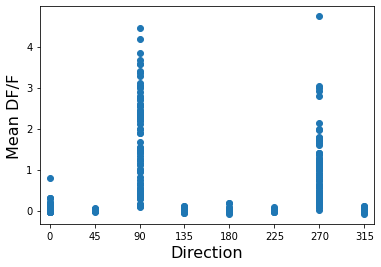

In [98]:
plt.plot(orientation, mean_response, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

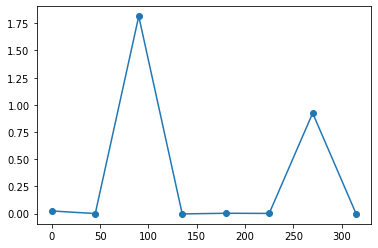

In [99]:
tuning = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    tuning[ii] = mean_response[ix==ii].mean()
plt.plot(orientations,tuning, 'o-')



In [100]:
# Excersize: repeat for temporal frequency!



<ErrorbarContainer object of 3 artists>

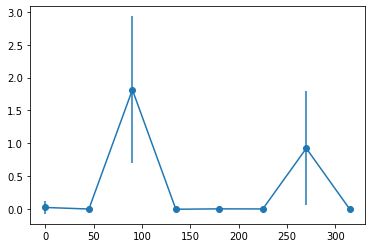

In [101]:
stdev = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    stdev[ii] = mean_response[ix==ii].std()
plt.errorbar(orientations, tuning, yerr=stdev, fmt='o-')

c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Orienation (degrees)')

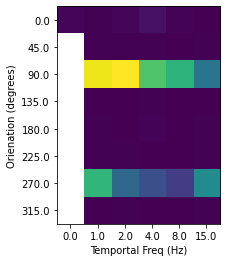

In [287]:
temp_freqs = np.unique(temp_freq)

tuning_array = np.empty((len(orientations),len(temp_freqs)))
for ii,ori in enumerate(orientations):
    for jj,tf in enumerate(temp_freqs):
        #print(ori)
        #print(tf)
        these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
        #print(sum(these_trials))
        tuning_array[ii,jj] = mean_response[these_trials].mean()
fig,ax = plt.subplots()
ax.imshow(tuning_array)
ax.set_xticks(range(len(temp_freqs)))
ax.set_xticklabels(temp_freqs)
ax.set_yticks(range(len(orientations)))
ax.set_yticklabels(orientations);
ax.set_xlabel("Temportal Freq (Hz)")
ax.set_ylabel("Orienation (degrees)")


In [309]:
# Would be good to include some sort of descriptive statistic here...
def shannon_information(tuning_array):
    """
    Compute the Shannon information of a tuning curve.

    This function was entirly generated by copiolot and it looks like entropy,
    not info...need to fix with the real thing
    
    
    """
    # normalize tuning_array
    tuning_array = tuning_array / np.nansum(tuning_array)
    # compute Shannon information
    shannon_info = -np.nansum(tuning_array * np.log2(tuning_array))
    return shannon_info


# But what does this mean???
shannon_information(tuning_array)


    

c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log2
  


3.2602877980568157

c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log2
  


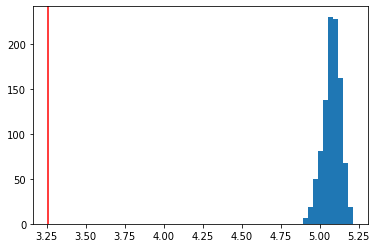

In [313]:
# To make interpretable, we need to do something fancy-er. Think  bootstrapping.
nboots = 1000
bootstrapped_info = np.zeros(nboots)
for nn in range(nboots):
    tmp_tuning_array = np.empty((len(orientations),len(temp_freqs)))

    # Randomly reorder mean response
    tmp_mean_response = np.random.permutation(mean_response)

    for ii,ori in enumerate(orientations):
        for jj,tf in enumerate(temp_freqs):
            #print(ori)
            #print(tf)
            these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
            #print(sum(these_trials))
            tmp_tuning_array[ii,jj] = tmp_mean_response[these_trials].mean()

    bootstrapped_info[nn] = shannon_information(tmp_tuning_array)

plt.hist(bootstrapped_info)
plt.axvline(shannon_information(tuning_array),color='r')

In [306]:
 shannon_information(tmp_tuning_array)

5.1178615848249365

In [300]:
tmp_mean_response = np.random.permutation(mean_response)
print(tmp_mean_response)


[-2.00432715e-03  2.41680503e+00  1.99570291e+00 -1.00015566e-02
  8.61174042e-01  1.00457389e-01 -2.20889606e-03 -4.24421181e-03
  3.60021177e-03 -1.14090242e-02  3.30063478e-02  2.25789648e-01
  2.75244366e+00 -2.27601675e-02  1.87968093e+00  7.33056666e-04
  7.39755260e-01  5.00965511e-05  9.72687556e-03 -1.05684176e-02
  2.13072145e-03 -1.67941724e-02 -2.17274468e-02 -5.26831873e-03
  2.41520322e-03 -3.27780472e-03 -4.57790400e-03  7.19518171e-03
  1.40600506e+00  9.79287156e-01  4.38517741e-03 -1.48424358e-02
  2.61117217e-01 -1.78142027e-02  2.49626743e-02  9.37114755e-01
 -1.65183375e-02  2.75443021e-03  2.42305973e-03 -1.56878799e-02
  2.62850042e-03  4.62145635e-02 -8.08252610e-03  8.51799165e-03
 -1.45393179e-02  7.60655735e-03  2.80511668e-03  2.83241063e-03
  9.96805524e-03  4.11327648e-03  1.77009427e+00 -4.67093172e-03
  1.26252348e+00 -2.18632834e-03  2.58446537e-03  4.13513939e-02
 -1.37371047e-04  8.16126711e-01  2.65800192e-04  2.94876206e-01
 -2.31853243e-03 -4.10254

<ipython-input-296-69dc6115fafe>:23: RuntimeWarning: Mean of empty slice.
  tuning_array[ii,jj] = another_mean_response[these_trials].mean()
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


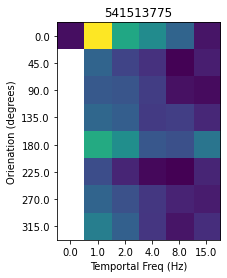

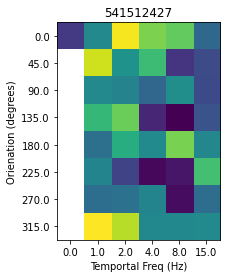

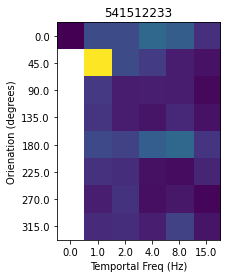

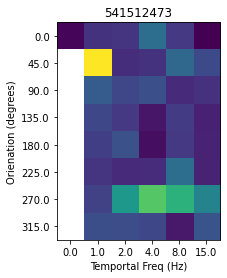

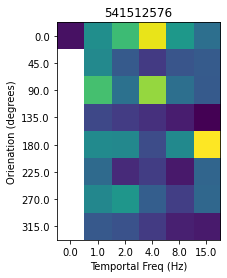

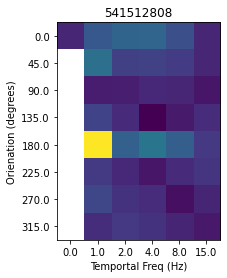

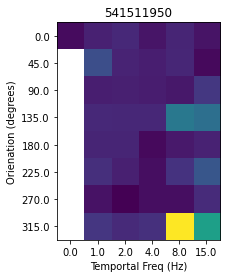

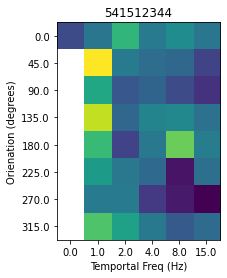

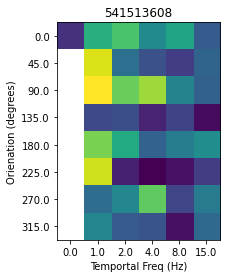

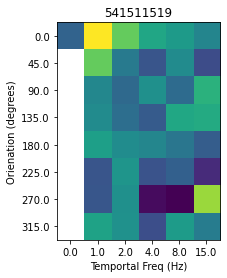

In [296]:
for ii in range(10):
    rand_cell_idx = np.random.randint(len(gratings.cell_id))

    another_dff = gratings.dfftraces[rand_cell_idx]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        orientation[ii] = stim_table.orientation[ii]
        temp_freq[ii] = stim_table.temporal_frequency[ii]
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

    another_mean_response = another_response.mean(axis =1)

    temp_freqs = np.unique(temp_freq)

    tuning_array = np.empty((len(orientations),len(temp_freqs)))
    for ii,ori in enumerate(orientations):
        for jj,tf in enumerate(temp_freqs):
            #print(ori)
            #print(tf)
            these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
            #print(sum(these_trials))
            tuning_array[ii,jj] = another_mean_response[these_trials].mean()
    fig,ax = plt.subplots()
    ax.imshow(tuning_array)
    ax.set_xticks(range(len(temp_freqs)))
    ax.set_xticklabels(temp_freqs)
    ax.set_yticks(range(len(orientations)))
    ax.set_yticklabels(orientations);
    ax.set_xlabel("Temportal Freq (Hz)")
    ax.set_ylabel("Orienation (degrees)")
    ax.set_title(gratings.cell_id[rand_cell_idx])


## We now interup our neuroscience programing
Up till now everything is descriptive- we are just looking at the data and describing it. What we really want to do is predict new data. In order to do this, we are going to fit a simple linear model that describes our tuning curve. Before we get that far, let's divert to the "DarwinExample" notebook to go though how model fitting and prediction might work on this kind of problem.

## Welcome back. 
This tuning curve problem can also be formulated as a one-hot encoding problem.

In [253]:
# Lets matrix for every stimulus condition
stims = np.vstack([orientation,temp_freq]).T

# Each stimulus condition has a unique identity
stimuli,stim_index,counts = np.unique(stims,axis=0,return_counts=True,return_inverse=True)

# How many are there?
print(len(stimuli))


41


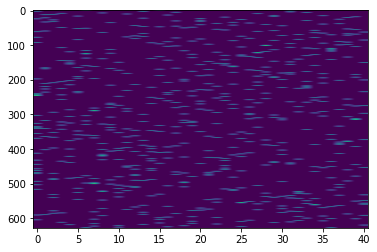

In [254]:
# Build the design matrix
X = np.zeros((len(stim_table),len(stimuli)))
for ii in range(len(stim_table)):
    X[ii,stim_index[ii]] = 1

fig,ax = plt.subplots()
ax.imshow(X,aspect='auto')

In [255]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, mean_response, test_size=0.5, random_state=42)


In [256]:
rfmodel = LinearRegression(fit_intercept=False).fit(X_train, y_train,)


In [257]:
# If we want to look at the model we fit, we can look at the predictions for any
# given stimulus. The easiest way to do this is to make a design matrix with a
# diagonal of all ones:
eyeX = np.eye(X.shape[1])
pred = rfmodel.predict(eyeX)

In [258]:
# Because we didn't fit an intercept, the predictions are the same as the as the
# model coefficients
rfmodel.coef_-pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

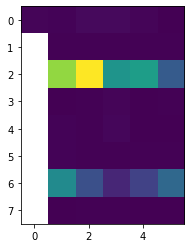

In [259]:
# We can plot the predicted response for each stimulus condition! This should
# look familiar... 
tuning_array = np.zeros((len(orientations),len(temp_freqs)))
for ii in range(len(pred)):
    ori_ix = np.where(orientations==stimuli[ii,0])[0]
    tf_ix = np.where(temp_freqs==stimuli[ii,1])[0]
    tuning_array[ori_ix,tf_ix]=pred[ii]
tuning_array[1:,0] = np.nan

fig,ax = plt.subplots()
ax.imshow(tuning_array)

In [260]:

scr_train = rfmodel.score(X_train,y_train)
scr_train

0.7941142710480253

In [261]:
# Now this is worse :(
scr_test = rfmodel.score(X_test,y_test)
scr_test

0.5737620030130027

In [219]:
train_prediction = np.zeros(len(gratings.cell_id))
test_prediction = np.zeros(len(gratings.cell_id))

for cc in range(len(gratings.dfftraces)):
    another_dff = gratings.dfftraces[cc]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        orientation[ii] = stim_table.orientation[ii]
        temp_freq[ii] = stim_table.temporal_frequency[ii]
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

    another_mean_response = another_response.mean(axis =1)

    another_X_train, another_X_test, another_y_train, another_y_test = train_test_split(X, another_mean_response, test_size=0.5,  random_state=42)
    
    rfmodel = LinearRegression(fit_intercept=False).fit(another_X_train, another_y_train,)
    train_prediction[cc] = rfmodel.score(another_X_train,another_y_train)

    test_prediction[cc] = rfmodel.score(another_X_test,another_y_test)


Text(0, 0.5, 'Test R^2')

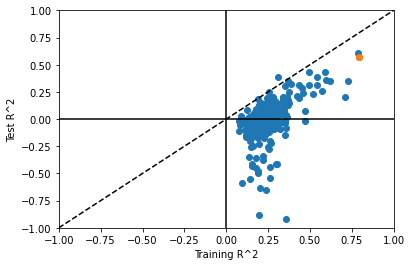

In [262]:
fig,ax = plt.subplots()
ax.scatter(train_prediction,test_prediction)
ax.scatter(scr_train,scr_test)

ax.plot([-1,1],[-1,1],'k--')
ax.plot([-1,1],[0,0],'k-')
ax.plot([0,0],[-1,1],'k-')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Training R^2")
ax.set_ylabel("Test R^2")